## Tracking a Train

In [1]:
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
import book_plots

In [2]:
def plot_g_h_results (measurements, filtered_data, title=''):
    plt.plot (filtered_data, '--',label='filter')
    plt.plot(measurements,label='measurement')
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

In [3]:
def g_h_filter (data, x0, dx, g, h, dt=1., pred=None):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.

    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    'pred' is an optional list. If provided, each prediction will be stored in it
    """
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

### Simulate the situation
So let's write a filter for a train. Its position is expressed as its position on the track in relation to some fixed point which we say is 0 km. I.e., a position of 1 means that the train is 1 km away from the fixed point. Velocity is expressed as meters per second. We perform measurement of position once per second, and the error is $\pm$ 500 meters. How should we implement our filter?

In [4]:
def compute_new_position(pos, vel, dt=1.):
    """ dt is the time delta in seconds."""
    return pos + (vel * dt)

def measure_position(pos):
    return pos + randn()*500

def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)

In [5]:
pos, vel = 23.*1000, 15.
zs = gen_train_data(pos, vel, 100)

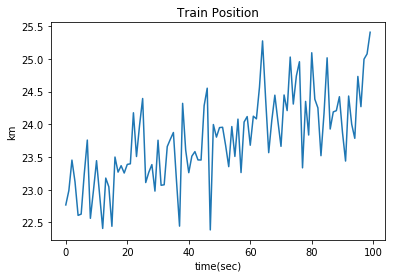

In [6]:
plt.plot(zs / 1000.)  # convert to km
book_plots.set_labels('Train Position', 'time(sec)', 'km')

We can see from the chart how poor the measurements are. No real train could ever move like that.
We know that the measurements are very inaccurate, so we don't want to give them much weight at all. To do this we need to choose a very small $g$. We also know that trains can not accelerate or decelerate quickly, so we also want a very small $h$.

For example:

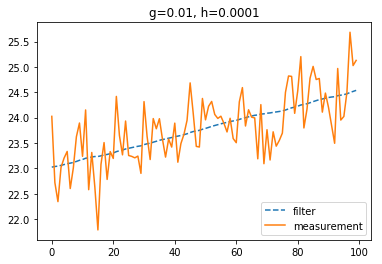

In [7]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

That is pretty good for an initial guess. Let's make $g$ larger to see the effect.

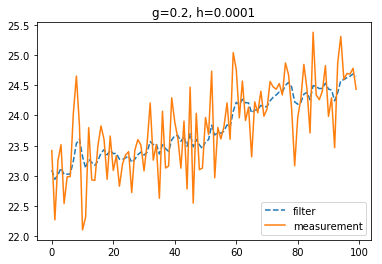

In [8]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.2, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.2, h=0.0001')

We made g=0.2 and we can see that while the train's position is smoothed, the estimated position (and hence velocity) fluctuates a lot in a very tiny frame, far more than a real train can do. So empirically we know that we want g<<0.2.

Now let's see the effect of a poor choice for $h$.

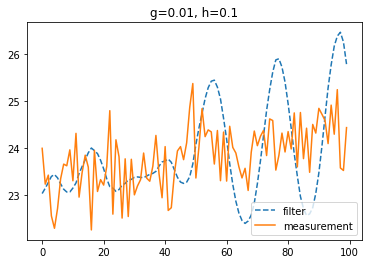

In [9]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=0.01, h=0.1)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.1')

Here the position changes smoothly thanks to the small $g$, but the large $h$ makes the filter very reactive to the measurements. This happens because in the course of a few seconds the rapidly changing measurement implies a very large velocity change, and a large  $h$ tells the filter to react to those changes quickly. Trains cannot change velocity quickly, so the filter is not doing a good job of filtering the data - the filter is changing velocity faster than a train can.

Finally, let's add some acceleration to the train. I don't know how fast a train can actually accelerate, but let's say it is accelerating at 0.2 m/sec^2.

In [10]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs)

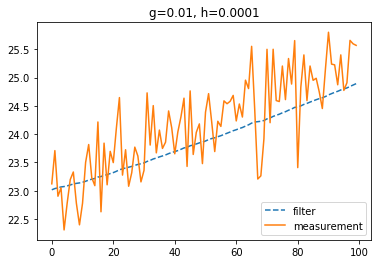

In [11]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

Here we see that the filter is not quite tracking the train anymore due to the acceleration. We can fiddle with $h$ to let it track better, at the expense of a less smooth filtered estimate.

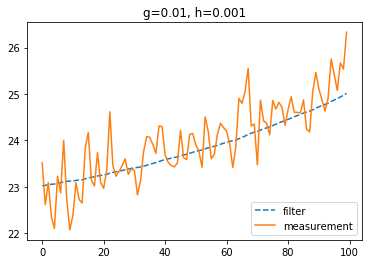

In [12]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.001')